In [1]:
import numpy as np
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint
import matplotlib.pyplot as pl
import copy

In [2]:
random_x = np.random.uniform(21, 37, 50).reshape((-1, 1))
random_y = np.random.uniform(21, 37, 50).reshape((-1, 1))
obs_np = np.concatenate([random_x, random_y], axis=1)

In [3]:
def J_vehicle(x_c):
    ret_array = np.array([[np.cos(x_c[-1]), 0.0], [np.sin(x_c[-1]), 0.0], [0.0, 1.0]])
    return ret_array

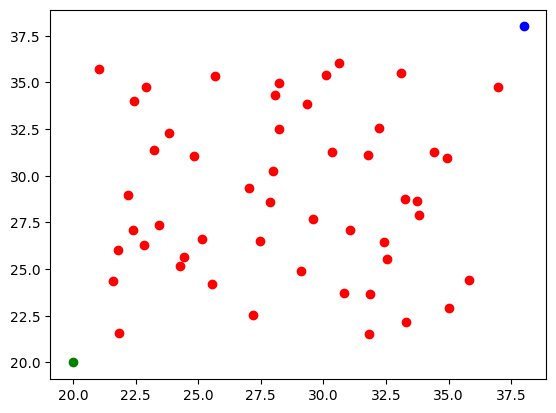

In [4]:
start_point = np.array([38.0, 38.0, -2.0])
end_point = np.array([20.0, 20.0])
pl.scatter(random_x, random_y, c="r")
pl.scatter(start_point[0], start_point[1], c="b")
pl.scatter(end_point[0], end_point[1], c="g")

In [5]:
def rollout_sc(control, start, ts=0.1, th=50):
    cur_state = copy.copy(start)
    points_list = []
    for i in range(th):
        J = J_vehicle(cur_state)
        x_dot = np.matmul(J, control)
        cur_state += x_dot * ts
        points_list.append(copy.copy(cur_state))
    return np.array(points_list)

In [6]:
control = np.array([1.0, -0.1])
points_np = rollout_sc(control, start_point)

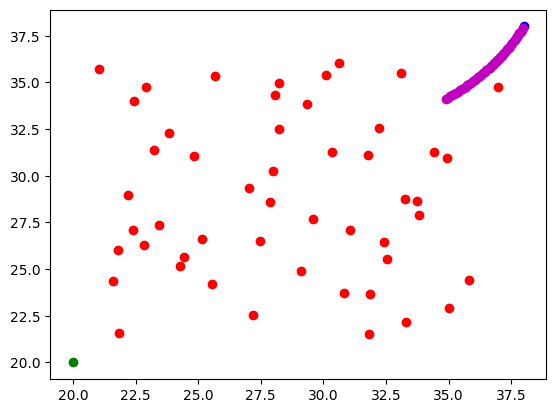

In [7]:
pl.scatter(random_x, random_y, c="r")
pl.scatter(start_point[0], start_point[1], c="b")
pl.scatter(end_point[0], end_point[1], c="g")
pl.scatter(points_np[:, 0], points_np[:, 1], c="m")

In [8]:
steps = np.arange(-3.1, 3.1, 0.05)

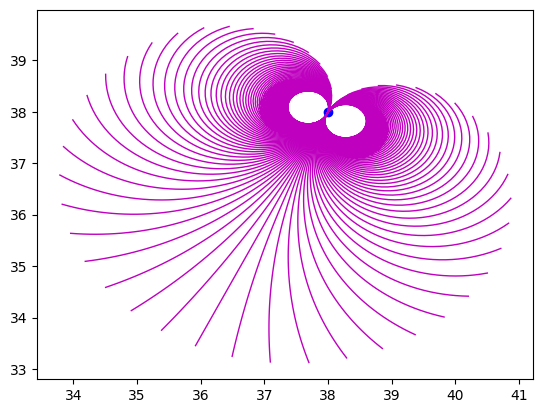

In [9]:
# holding controls
for i in range(len(steps)):
    control = np.array([1.0, steps[i]])
    points_np = rollout_sc(control, start_point)
    pl.plot(points_np[:, 0], points_np[:, 1], c="m", lw=1)
pl.scatter(start_point[0], start_point[1], c="b")
# pl.scatter(end_point[0],end_point[1],c='g')
# pl.scatter(random_x,random_y,c='r')

In [10]:
control = np.array([0.0, 0.0])
points_np = rollout_sc(control, start_point)

In [11]:
def ttc_rollout(control, start, ts=0.1, th=50):
    cur_state = copy.copy(start)
    count = 0.0
    dist_sum = 0.0
    for i in range(th):
        J = J_vehicle(cur_state)
        x_dot = np.matmul(J, control)
        cur_state += x_dot * ts
        count += 1.0
        d_cost = np.linalg.norm(cur_state[:2] - end_point)
        # dist_sum+=d_cost
        dist = np.linalg.norm(cur_state[:2] - obs_np, axis=1)
        if np.min(dist) < 0.5:
            # cost=(dist_sum/count)+(50./((count*ts)))
            cost = d_cost + (50.0 / ((count * ts) ** 2))
            return cost
    # cost=(dist_sum/count)#+(5./((count*ts)))
    cost = d_cost
    return cost


def rollout(x_dot, cur_point, ts=0.1, th=50):
    x_c = copy.copy(cur_point)
    x_dot_r = x_dot.reshape(-1)
    cost_v = 0.0
    for i in range(0, th):
        jac_v = J_vehicle(x_c)
        nextstep = np.matmul(jac_v, x_dot_r) * ts
        x_c = x_c + nextstep
        norm_dist = np.linalg.norm(x_c[:2] - end_point)
        obs_ratio = 15.0 / (
            ts * (i + 1) * (np.min(np.linalg.norm(x_c[:2] - obs_np, axis=1)))
        )
        # obs_ratio=np.max((1./(2.5*sigma))*(np.exp(-0.5*(np.linalg.norm(x_c[:2]-obs_np,axis=1)/sigma)**2)))
        # obs_ratio=np.max(np.exp(-(np.linalg.norm(x_c[:2]-obs_np,axis=1))**2))
        if norm_dist < 0.1:
            return cost_v
        cost_v = cost_v + (norm_dist) + (obs_ratio)
    return cost_v

In [12]:
%%time
ttc_rollout(control, start_point)

CPU times: user 2.97 ms, sys: 0 ns, total: 2.97 ms
Wall time: 2.74 ms


25.45584412271571

In [13]:
%%time
rollout(control, start_point)

CPU times: user 3.19 ms, sys: 0 ns, total: 3.19 ms
Wall time: 3 ms


1471.7303660269233

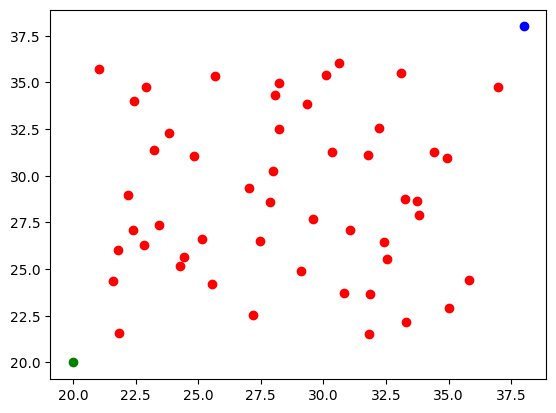

In [14]:
pl.scatter(points_np[:, 0], points_np[:, 1], c="m", s=4)
pl.scatter(start_point[0], start_point[1], c="b")
pl.scatter(end_point[0], end_point[1], c="g")
pl.scatter(random_x, random_y, c="r")

In [15]:
single_con = np.array([1.5, 0.0])
ubounds = np.array([1.5, 1.0])
lbounds = np.array([0.0, -1.0])
ubounds = ubounds.reshape(-1)
lbounds = lbounds.reshape(-1)
LinBounds = Bounds(lbounds, ubounds)
# A_b=np.eye(2)
# LinBounds=LinearConstraint(A_b,lbounds,ubounds)

In [16]:
# start_point=np.array([27.,36.5,-2.5])
start_point = np.array([35.0, 35.0, -1.5])
end_point = np.array([20.0, 20.0])

In [17]:
%%time
res = minimize(
    ttc_rollout,
    single_con,
    method="slsqp",
    args=(start_point),
    bounds=LinBounds,
    options={"ftol": 0.5},
)

CPU times: user 10.1 ms, sys: 0 ns, total: 10.1 ms
Wall time: 9.34 ms


In [18]:
%%time
res = minimize(
    rollout,
    single_con,
    method="slsqp",
    args=(start_point),
    bounds=LinBounds,
    options={"ftol": 0.5},
)

CPU times: user 6.72 ms, sys: 3.36 ms, total: 10.1 ms
Wall time: 9.38 ms


In [19]:
res.x

array([1.5       , 0.22621003])

In [20]:
pos = rollout_sc(res.x, start_point)

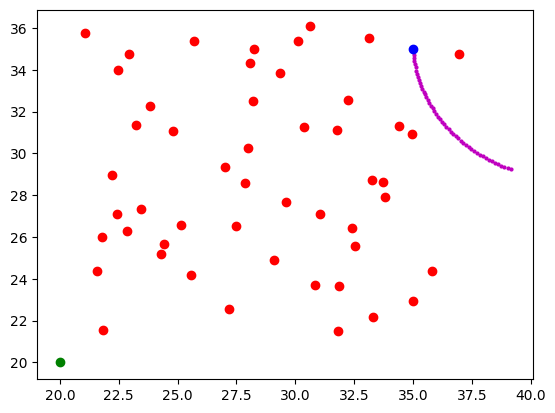

In [21]:
pl.scatter(pos[:, 0], pos[:, 1], c="m", s=4)
pl.scatter(start_point[0], start_point[1], c="b")
pl.scatter(end_point[0], end_point[1], c="g")
pl.scatter(random_x, random_y, c="r")
# pl.xlim([24,34])
# pl.ylim([24,34])

In [22]:
def integrate_next_step(x_0, x_dot, ts_c=0.1):
    x_c = copy.copy(x_0)
    jac_v = J_vehicle(x_c)
    x_c += np.matmul(jac_v, x_dot) * ts_c
    return x_c

In [23]:
def ttc_checkCol(control, start, ts=0.1, th=40):
    cur_state = copy.copy(start)
    count = 0.0
    dist_sum = 0.0
    for i in range(th):
        J = J_vehicle(cur_state)
        x_dot = np.matmul(J, control)
        cur_state += x_dot * ts
        dist = np.linalg.norm(cur_state[:2] - obs_np, axis=1)
        if np.min(dist) < 1.0:
            return i * ts
    return th * ts

In [24]:
ttc_checkCol(res.x, start_point)

4.0

# Fast rollout in Fortran

In [25]:
import fast_rollout

## Docs for args

In [26]:
print(fast_rollout.rollout.__doc__)

cost = rollout(con,init_x,targ_x,obs,[obs_n,obs_r_frac,x_len,con_len,n,ts])

Wrapper for ``rollout``.

Parameters
----------
con : input rank-1 array('d') with bounds (con_len)
init_x : input rank-1 array('d') with bounds (x_len)
targ_x : input rank-1 array('d') with bounds (-1 + x_len)
obs : input rank-2 array('f') with bounds (obs_n,-1 + x_len)

Other Parameters
----------------
obs_n : input int, optional
    Default: shape(obs, 0)
obs_r_frac : input float, optional
    Default: 15.0
x_len : input int, optional
    Default: shape(init_x, 0)
con_len : input int, optional
    Default: shape(con, 0)
n : input int, optional
    Default: 50
ts : input float, optional
    Default: 0.1

Returns
-------
cost : float



In [27]:
%%timeit
rollout(control, start_point)

1.17 ms ± 67.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
%%timeit
fast_rollout.rollout(
    control,
    init_x=start_point,
    targ_x=end_point,
    obs=obs_np,
)

31.9 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Supply args to for fast_rollout in scipy

In [29]:
%%time
start_point = np.array([38.0, 38.0, -2.0])
end_point = np.array([20.0, 20.0])
# cur_point=copy.copy(start_point)

cur_con = np.array([1.5, 0.0])


cur_point = start_point.copy()

start_point = np.random.uniform(21, 37, 3)
start_point[-1] = -2.0
end_point = np.random.uniform(21, 37, 2)

print(start_point, end_point)

cur_point = copy.copy(start_point)
pos_list = []
vel_list = []
for i in range(0, 500):
    pos_list.append(copy.copy(cur_point))
    res = minimize(
        fast_rollout.rollout,
        cur_con,
        method="slsqp",
        args=(cur_point, end_point, obs_np),
        bounds=LinBounds,
        options={"ftol": 0.1},
    )
    #     res=minimize(rollout,cur_con,method='slsqp',args=(cur_point),bounds=LinBounds,options={'ftol':0.1})
    cur_con = copy.copy(res.x)
    cur_con = res.x
    next_point = integrate_next_step(cur_point, cur_con)
    cur_point = next_point
    vel_list.append(cur_con)
    if np.linalg.norm(cur_point[:2] - end_point) < 0.1:
        break
print(i)

[34.10374444 34.36203743 -2.        ] [25.32799555 28.49243855]
499
CPU times: user 309 ms, sys: 6.4 ms, total: 316 ms
Wall time: 310 ms


# new

In [30]:
%%time
start_point = np.array([38.0, 38.0, -2.0])
end_point = np.array([20.0, 20.0])
# cur_point=copy.copy(start_point)
cur_point = start_point.copy()
cur_con = np.array([1.5, 0.0])

start_point = np.random.uniform(21, 37, 3)
start_point[-1] = -2.0
end_point = np.random.uniform(21, 37, 2)


def bb(
    start_point,
    end_point,
    start_con,
    LinBounds,
    obs_np,
    n=500,
):
    cur_point = copy.copy(start_point)
    pos_list = []
    vel_list = []
    cur_con = copy.copy(start_con)
    for i in range(0, n):
        pos_list.append(copy.copy(cur_point))
        res = minimize(
            fast_rollout.rollout,
            cur_con,
            method="slsqp",
            args=(cur_point, end_point, obs_np),
            bounds=LinBounds,
            options={"ftol": 0.1},
        )
        #     res=minimize(rollout,cur_con,method='slsqp',args=(cur_point),bounds=LinBounds,options={'ftol':0.1})
        cur_con = copy.copy(res.x)
        cur_con = res.x
        next_point = integrate_next_step(cur_point, cur_con)
        cur_point = next_point
        vel_list.append(cur_con)
        if np.linalg.norm(cur_point[:2] - end_point) < 0.1:
            break
    #     print(i)
    return pos_list, vel_list


bb(start_point, end_point, cur_con, LinBounds, obs_np, n=500)

CPU times: user 132 ms, sys: 3.02 ms, total: 135 ms
Wall time: 134 ms


([array([33.0880695 , 36.02567067, -2.        ]),
  array([33.02564747, 35.88927605, -1.99894375]),
  array([32.96336955, 35.75281558, -1.99716274]),
  array([32.90133476, 35.61624441, -1.99522771]),
  array([32.83956436, 35.47955346, -1.93280367]),
  array([32.78644153, 35.33927529, -1.86948939]),
  array([32.74230082, 35.195917  , -1.80704782]),
  array([32.70719184, 35.05008368, -1.74527335]),
  array([32.68141326, 34.90383828, -1.68511663]),
  array([32.66454749, 34.75695073, -1.62565807]),
  array([32.6565365 , 34.61107581, -1.56809543]),
  array([32.65679117, 34.51678458, -1.49440797]),
  array([32.66387275, 34.42426004, -1.42030292]),
  array([32.675911  , 34.34487294, -1.37015926]),
  array([32.69160933, 34.26768323, -1.32286683]),
  array([32.71062411, 34.19256685, -1.27797566]),
  array([32.73270773, 34.11931793, -1.23491736]),
  array([32.75368907, 34.0592179 , -1.18699448]),
  array([32.77706728, 34.00132635, -1.14191445]),
  array([32.80240967, 33.94590509, -1.10030416]),


In [31]:
import forward_prop_traj

In [32]:
start_point = np.random.uniform(21, 37, 3)
start_point[-1] = -2.0
end_point = np.random.uniform(21, 37, 2)

In [33]:
%%timeit
pos_list, vel_list = bb(
    start_point=start_point,
    end_point=end_point,
    start_con=cur_con,
    n=2000,
    LinBounds=LinBounds,
    obs_np=obs_np,
)

58.9 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%%timeit
# r = a(
r = forward_prop_traj.prop_traj(
    start_point=start_point,
    end_point=end_point,
    start_con=cur_con,
    N=2000,
    ftol=0.1,
    LinBounds=LinBounds,
    obs_np=obs_np,
)

26.7 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


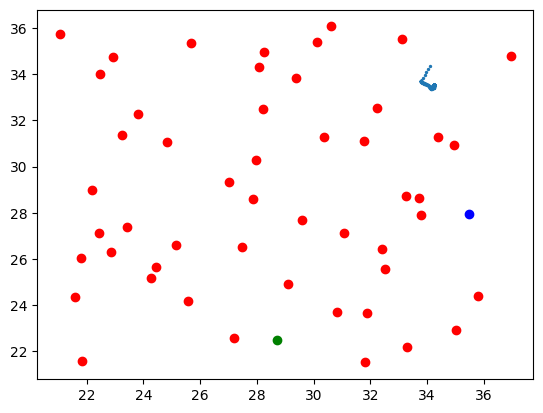

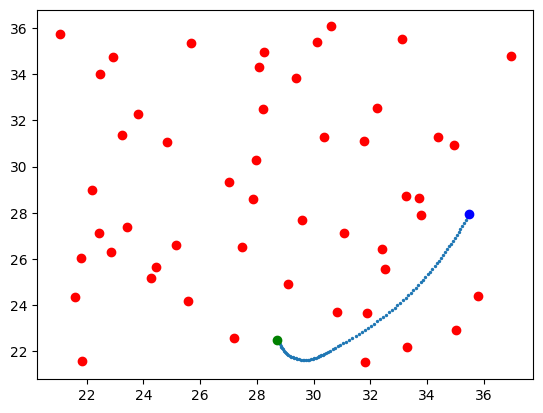

In [36]:
pos_np = np.array(pos_list)
vel_np = np.array(vel_list)

pl.scatter(pos_np[:, 0], pos_np[:, 1], s=2)
pl.scatter(random_x, random_y, c="r")
pl.scatter(start_point[0], start_point[1], c="b")
pl.scatter(end_point[0], end_point[1], c="g")
pl.show()

r = forward_prop_traj.prop_traj(
    start_point=start_point,
    end_point=end_point,
    start_con=cur_con,
    N=2000,
    ftol=0.1,
    LinBounds=LinBounds,
    obs_np=obs_np,
)

pos_np = np.array(r[0])
vel_np = np.array(r[1])


pl.scatter(pos_np[:, 0], pos_np[:, 1], s=2)
pl.scatter(random_x, random_y, c="r")
pl.scatter(start_point[0], start_point[1], c="b")
pl.scatter(end_point[0], end_point[1], c="g")

## *Correctness by comparing both funcs*

In [37]:
for i in range(50):
    c = np.random.rand(2) * 10
    x = np.random.rand(3) * 10
    print(rollout(c, x), fast_rollout.rollout(c, x, end_point, obs_np))

1536.973787319348 1536.9737871339432
1771.0687399593396 1771.0687353802987
1632.189767617373 1632.1897671594354
1693.613349558267 1693.6133493899315
1746.46505153017 1746.465054735522
1363.067664999071 1363.0676647108728
1246.2363097504126 1246.2363096690249
1222.7890287918494 1222.7890285229803
1654.0145219978397 1654.0145196162998
1438.011295085055 1438.0112964030814
1554.308706616334 1554.3087059135046
1182.1392714761637 1182.1392702313221
1413.0441843003575 1413.044184048647
1315.1591083345095 1315.1591076823388
1405.3873684155806 1405.3873669321083
1494.2942279650317 1494.294227273756
1642.6690331301422 1642.6690327158026
1621.2591257733075 1621.2591238624989
1490.042643665308 1490.0426430463826
1373.4363020446506 1373.436302948981
1343.1872906195022 1343.1872901979386
1381.1922654524071 1381.1922651409811
1568.9618854154567 1568.9618850374654
1304.6136971218127 1304.6136948838634
1456.1539376510734 1456.1539380857432
1688.0132561610064 1688.013255842059
1651.445658819321 1651.445